<a href="https://colab.research.google.com/github/casanovaalonso/MathForDL/blob/main/02_triton_fused_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.3 MB/s eta 0:00:00


In [2]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

In [3]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}")

In [4]:
def is_hip():
  """
  I think this is in the tutorial to illustrate how triton can work with
  different backends.
  HIP is a backend that allows you to execute the same code in AMD and nVidia GPUs
  In the tutorial there is another function to check for cdna but I'm going to
  skip it since this is going to use CUDA.
  """
  return triton.runtime.driver.active.get_current_target().backend == "hip"

### Numerical Stability in Softmax

When computing the softmax of a vector $\mathbf{z} = (z_1, z_2, \dots, z_n)$, the function is defined as:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}} \quad \text{for each element} \, i = 1, 2, \dots, n
$$

To improve numerical stability and prevent overflow when computing the exponentials, we subtract the maximum value $ \max(\mathbf{z}) $ from each element in the vector:

$$
\tilde{z}_i = z_i - \max(\mathbf{z})
$$

The softmax applied to the shifted vector $ \tilde{\mathbf{z}} = (\tilde{z}_1, \tilde{z}_2, \dots, \tilde{z}_n) $ becomes:

$$
\text{softmax}(\tilde{z}_i) = \frac{e^{\tilde{z}_i}}{\sum_{j=1}^{n} e^{\tilde{z}_j}} = \frac{e^{z_i - \max(\mathbf{z})}}{\sum_{j=1}^{n} e^{z_j - \max(\mathbf{z})}}
$$

This simplifies to:

$$
\text{softmax}(z_i) = \frac{e^{z_i} \cdot e^{-\max(\mathbf{z})}}{\sum_{j=1}^{n} e^{z_j} \cdot e^{-\max(\mathbf{z})}} = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

Thus, subtracting the maximum element does not change the result of the softmax, as the shift cancels out in the numerator and denominator. This shift helps to prevent numerical issues like overflow or underflow in the computation.


In [5]:
def naive_softmax(x):
  """
  Compute row-wise softmax of a tensor using Pytorch
  """
  x_max = torch.max(x, dim=1, keepdim=True)[0]
  x_exp = torch.exp(x - x_max)
  x_sum = torch.sum(x_exp, dim=1, keepdim=True)
  return x_exp / x_sum

Accordin to [this](https://isamu-website.medium.com/understanding-the-triton-tutorials-part-1-6191b59ba4c) article `tl.load` function loads the data directly into the SRAM of the GPU allowing a faster computation.

All of this tutorial presents the idea of using this feature to increase the speed of the operations by laveraging the SRAM. We will make triton iterate over the rows of the matrix and load the entire row in the SRAM of the GPU, then we will compute everything and return the result.

Let me put a visual example of how the code works to make it easier for the reader.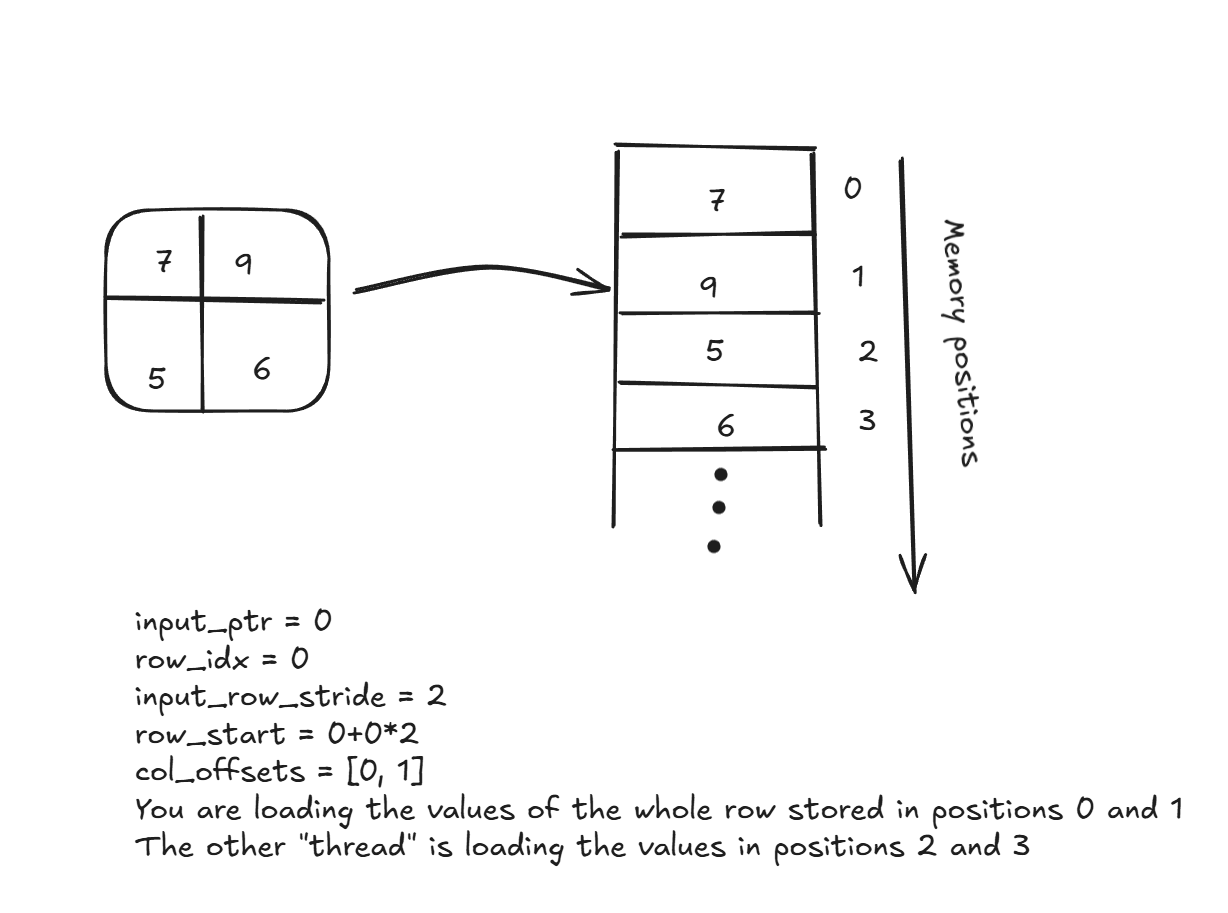

In [7]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_cols, BLOCK_SIZE: tl.constexpr):
  row_idx = tl.program_id(0)
  row_start_ptr = input_ptr + row_idx * input_row_stride
  col_offsets = tl.arange(0, BLOCK_SIZE)
  input_ptrs = row_start_ptr + col_offsets
  row = tl.load(input_ptrs, mask=col_offsets < n_cols, other=-float("inf")) # since e^-inf = 0 we pad the rows with that value is BLOCK_SIZE > n_cols
  row_max = tl.max(row, axis=0)
  row_minus_max = row - row_max
  numerator = tl.exp(row_minus_max)
  denominator = tl.sum(numerator, axis=0)
  output = numerator / denominator
  output_row_start_ptr = output_ptr + row_idx * output_row_stride
  output_ptrs = output_row_start_ptr + col_offsets
  tl.store(output_ptrs, output, mask=col_offsets < n_cols)


In [9]:
def softmax(x):
  n_rows, n_cols = x.shape
  BLOCK_SIZE = triton.next_power_of_2(n_cols)
  num_warps = 4 # Threads (?)
  if BLOCK_SIZE > 2048:
    num_warps = 8
  if BLOCK_SIZE > 4096:
    num_warps = 16
  y = torch.empty_like(x)
  softmax_kernel[(n_rows,)](y, x, x.stride(0), y.stride(0), n_cols, num_warps=num_warps, BLOCK_SIZE=BLOCK_SIZE)
  return y


In [10]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

In [12]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

softmax-performance:
          N      Triton       Torch
0     256.0  154.005358  205.076235
1     384.0  217.345544  217.688339
2     512.0  221.438403  216.593188
3     640.0  225.502070  213.128535
4     768.0  225.441870  215.442814
5     896.0  226.838756  211.673472
6    1024.0  227.445704  213.179893
7    1152.0  227.840941  141.703608
8    1280.0  228.518416  153.965142
9    1408.0  229.294509  166.837825
10   1536.0  228.749604  176.440854
11   1664.0  228.268076  189.123655
12   1792.0  228.847558  198.488336
13   1920.0  228.495296  207.418538
14   2048.0  228.642683  212.950249
15   2176.0  230.117778  223.594575
16   2304.0  230.630382  232.664285
17   2432.0  231.165384  232.100525
18   2560.0  230.424121  237.080493
19   2688.0  230.999894  240.329844
20   2816.0  230.810946  241.120107
21   2944.0  230.094774  241.800137
22   3072.0  230.712120  243.414590
23   3200.0  230.050004  243.619895
24   3328.0  230.258419  243.914052
25   3456.0  230.251518  243.721583
26   35